In [83]:
# Descripción: Este programa utiliza RNN en su versión de LSTM
#              Para predecir el precio de cierre de BTC usando los 60 days de stock price

In [84]:
# Importamos las librerías

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


In [85]:
symbol = "BTC-USD"
start_date = "2016-06-12"
end_date = "2023-06-11"

# Obtener los datos históricos del Bitcoin desde Yahoo Finance
df = yf.download(symbol, start=start_date, end=end_date)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-06-12,609.684021,684.843994,607.039001,672.783997,672.783997,277084992
2016-06-13,671.653992,716.004028,664.487000,704.375977,704.375977,243295008
2016-06-14,704.504028,704.504028,662.804016,685.559021,685.559021,186694000
2016-06-15,685.684998,696.302979,672.560974,694.468994,694.468994,99223800
2016-06-16,696.523010,773.721985,696.523010,766.307983,766.307983,271633984
...,...,...,...,...,...,...
2023-06-06,25732.109375,27313.820312,25434.867188,27238.783203,27238.783203,21929670693
2023-06-07,27235.650391,27332.181641,26146.988281,26345.998047,26345.998047,19530045082
2023-06-08,26347.654297,26797.513672,26246.664062,26508.216797,26508.216797,11904824295


In [86]:
# Obtener el número de columnas y filas del dataset
df.shape

(2555, 6)

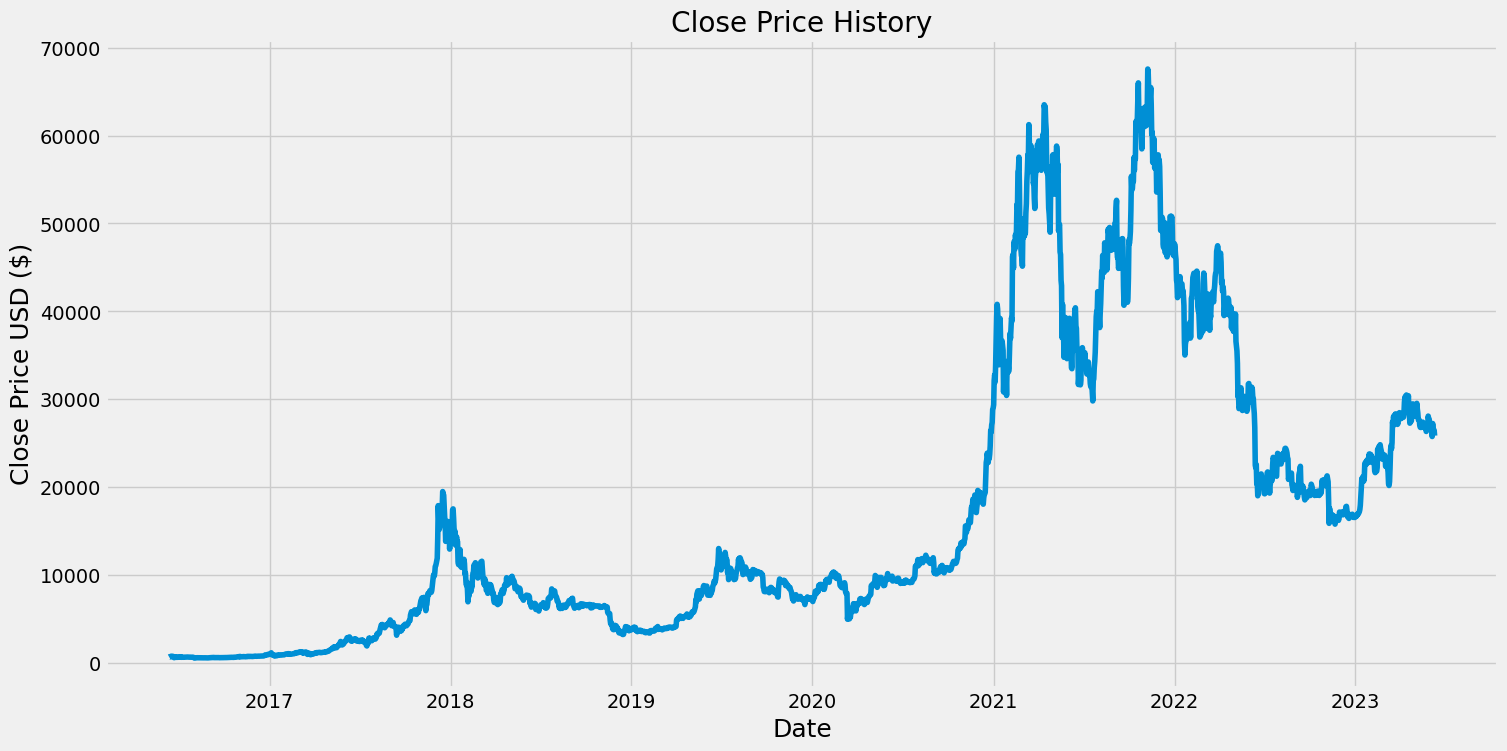

In [87]:
#Visualizar the precio de cierre
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize =18)
plt.show()

In [88]:
# Crear un nuevo datafrome con solo la columna de Precio de cierre
data = df.filter(['Close'])
# Convertimos el dataframe a un arrelgo numpy
dataset = data.values
# Obtenemos el número de filas para entrenar el modelo
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

2044

In [89]:
# Escalamos los datos
scaler  = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00186989],
       [0.00234128],
       [0.00206051],
       ...,
       [0.38736196],
       [0.38694653],
       [0.37755917]])

In [90]:
# Crear el datset de entrenamiento
# Creamos el dataset de entrenamiento a escala
train_data =scaled_data[0:training_data_len, :]
# Dividmos la data en x_train e y_train dataset
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i,0])
  if i<= 60:
    print(x_train)
    print(y_train)
    print()


[array([0.00186989, 0.00234128, 0.00206051, 0.00219346, 0.00326537,
       0.00300576, 0.00311495, 0.00322766, 0.00283144, 0.0017784 ,
       0.00072592, 0.00114164, 0.00175821, 0.00175558, 0.00122206,
       0.00160864, 0.00148518, 0.00137908, 0.00187814, 0.0019223 ,
       0.00233122, 0.00165921, 0.0020322 , 0.00183771, 0.00193774,
       0.00138911, 0.00177647, 0.00154426, 0.00152038, 0.001495  ,
       0.00174705, 0.0015966 , 0.00165046, 0.00172771, 0.00169059,
       0.00196949, 0.0018747 , 0.00187109, 0.00176397, 0.00175393,
       0.00153917, 0.00161283, 0.00169831, 0.00159106, 0.00155655,
       0.00159487, 0.00160506, 0.00163426, 0.00160524, 0.00115214,
       0.00087746, 0.        , 0.00028186, 0.00045993, 0.00041149,
       0.00060151, 0.0006748 , 0.00065039, 0.00060186, 0.00066605])]
[0.0006215363192980279]



In [91]:
# Convertimos el dataset de x e y_train en arreglos numpy
x_train, y_train = np.array(x_train), np.array(y_train)

In [92]:
# Remodelamos los datos
x_train= np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

x_train.shape

(1984, 60, 1)

In [93]:
# Creamos el Modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [94]:
# Compilamos el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

In [95]:
# Entrenamos el modelo
model.fit(x_train, y_train, batch_size=1, epochs=1)

1984/1984 [==============================] - 72s 34ms/step - loss: 0.0025


In [96]:
# Crear el Dataset de prueba
# Creamos un nuevo arreglo conteniendo los valores escalados del index 
test_data = scaled_data[training_data_len -60: , :]
# Creamos los Datasets x_test e y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])
   

In [97]:
# Convertir la data a un arreglo numpy
x_test = np.array(x_test)

In [98]:
#Reformar la data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [99]:
#Obtener el modelo con los valores predecidos
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)



16/16 [==============================] - 1s 19ms/step


In [100]:
#Evaluar el modelo, obtner el RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

4388.002754939829

<ipython-input-101-2f21773ea9ff>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


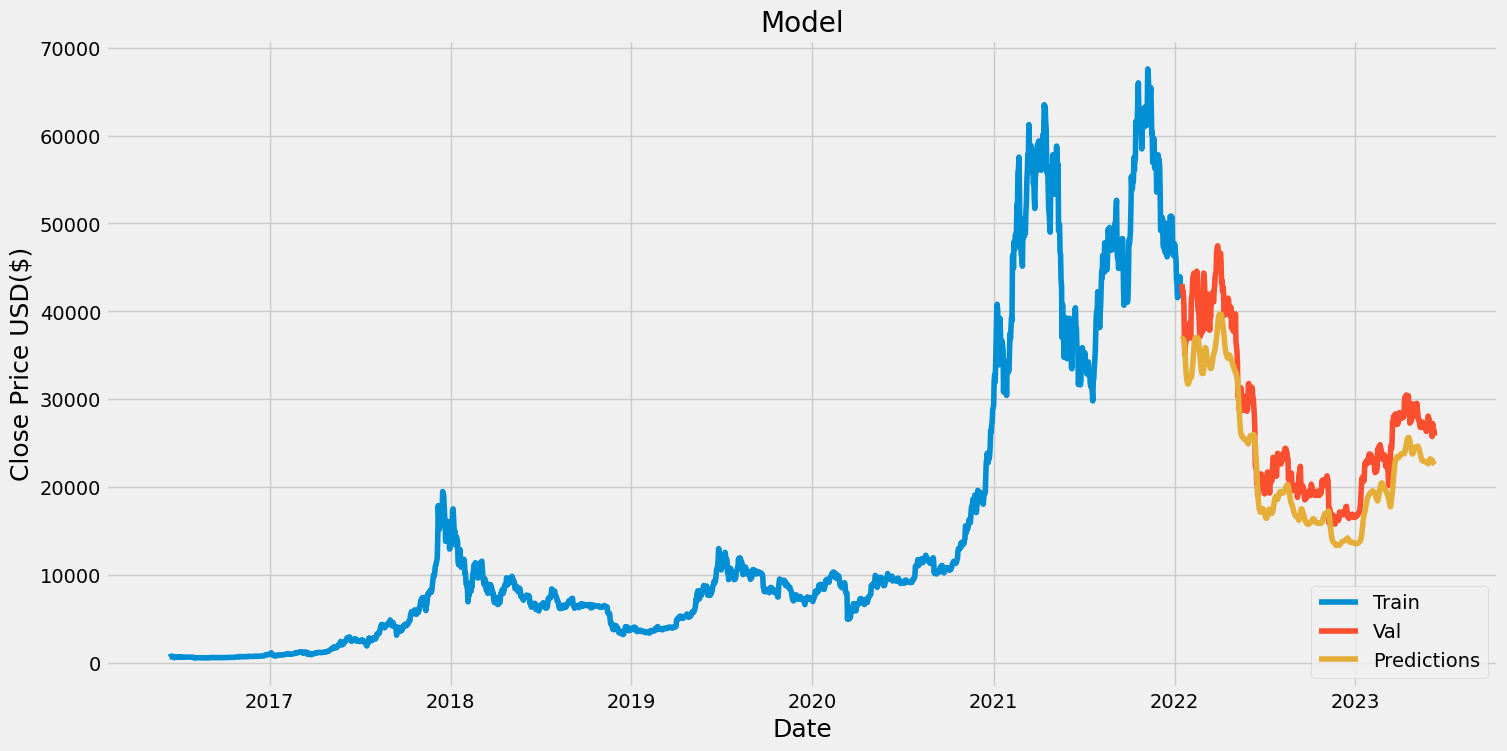

In [101]:
#Plot the data

train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

#visualiar los datos
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train','Val', 'Predictions'], loc='lower right')
plt.show()

In [102]:
#Show the valid and predicte prices
valid

,Close,Predictions
Date,,
2022-01-16,43113.878906,36805.398438
2022-01-17,42250.550781,36892.546875
2022-01-18,42375.632812,36853.414062
2022-01-19,41744.328125,36776.968750
2022-01-20,40680.417969,36613.417969
...,...,...
2023-06-06,27238.783203,22890.732422
2023-06-07,26345.998047,22827.259766
2023-06-08,26508.216797,22725.150391


In [103]:
#
symbol = "BTC-USD"
start_date = "2016-06-12"
end_date = "2023-06-11"

# Obtener los datos históricos del Bitcoin desde Yahoo Finance
btc_quote = yf.download(symbol, start=start_date, end=end_date)
btc_quote
#Create a newdataframe

new_df =btc_quote.filter(['Close'])
#Obtener los ultimos 60 dys de precio de cierre y convertilos dataframe en un arrelgo
last_60_days= new_df[-60:].values
#Escalar los datos entre 0 y 1
last_60_days_scaled =scaler.transform(last_60_days)
#Crear lista acia
X_test=[]
#Append 
X_test.append(last_60_days_scaled)
#Convertir los datos a arreglo numpy
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#obtener el precio de preddicoin
pred_price = model.predict(X_test)
#Descacer escalado
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 33ms/step
[[22443.45]]


In [104]:
symbol = "BTC-USD"
start_date = "2023-06-13"
end_date = "2023-06-13"

# Obtener los datos históricos del Bitcoin desde Yahoo Finance
btc_quote2= yf.download(symbol, start=start_date, end=end_date)
print(btc_quote2['Close'])


[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BTC-USD: Data doesn't exist for startDate = 1686614400, endDate = 1686614400
Series([], Name: Close, dtype: float64)
